In [1]:
import csv
import numpy as np
import tensorflow as tf 
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

In [2]:
dataset = 'model/point_history_classifier/point_history.csv'
model_save_path = 'model/point_history_classifier/point_history_classifier.hdf5'

In [3]:
NUM_CLASSES =4 

In [4]:
TIME_STEPS = 16
DIMENSION = 2

In [5]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1,(TIME_STEPS*DIMENSION)+ 1)))

In [6]:
Y_dataset = np.loadtxt(dataset, delimiter=',',dtype='int32', usecols=(0))

/var/folders/v6/rj0rjt8x0c9_f_dcfqgnsg6r0000gn/T/ipykernel_74330/2184582132.py:1: DeprecationWarning: loadtxt(): Parsing an integer via a float is deprecated.  To avoid this warning, you can:
    * make sure the original data is stored as integers.
    * use the `converters=` keyword argument.  If you only use
      NumPy 1.23 or later, `converters=float` will normally work.
    * Use `np.loadtxt(...).astype(np.int64)` parsing the file as
      floating point and then convert it.  (On all NumPy versions.)
  (Deprecated NumPy 1.23)
  Y_dataset = np.loadtxt(dataset, delimiter=',',dtype='int32', usecols=(0))


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, Y_dataset, train_size=0.75, random_state=RANDOM_SEED)

In [8]:
use_lstm = False
model = None

if use_lstm:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Reshape((TIME_STEPS, DIMENSION), input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(16, input_shape=[TIME_STEPS, DIMENSION]),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layer.Dense(NUM_CLASSES, activation='softmax')
    ])
else:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 24)                792       
                                                                 
 dropout_1 (Dropout)         (None, 24)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                250       
                                                                 
Total params: 1042 (4.07 KB)
Trainable params: 1042 (4.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)

es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [11]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [12]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf

# Configuration
RANDOM_SEED = 42
NUM_CLASSES = 4
HISTORY_LENGTH = 16
np.random.seed(RANDOM_SEED)

print("=" * 60)
print("TRAINING POINT HISTORY CLASSIFIER")
print("=" * 60)

# 1. Load data
print("\n1️⃣ Loading data...")
X_dataset = np.loadtxt('model/point_history_classifier/point_history.csv', 
                        delimiter=',', dtype='float32', usecols=list(range(0, 32)))
Y_dataset = np.loadtxt('model/point_history_classifier/point_history.csv', 
                        delimiter=',', dtype='int32', usecols=(32,))

print(f"   ✅ Loaded {len(X_dataset)} samples")

# 2. Split data
print("\n2️⃣ Splitting data...")
X_train, X_test, Y_train, Y_test = train_test_split(
    X_dataset, Y_dataset, 
    train_size=0.75, 
    random_state=RANDOM_SEED
)

print(f"   ✅ Training: {len(X_train)}, Testing: {len(X_test)}")

# 3. Build model
print("\n3️⃣ Building model...")
model = Sequential([
    Input((HISTORY_LENGTH * 2, )),
    Dropout(0.2),
    Dense(20, activation='relu'),
    Dropout(0.4),
    Dense(10, activation='relu'),
    Dense(NUM_CLASSES, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# 4. Setup callbacks
cp_callback = ModelCheckpoint(
    'model/point_history_classifier/point_history_classifier.hdf5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True
)

es_callback = EarlyStopping(
    monitor='val_loss',
    patience=20,
    verbose=1
)

# 5. Train
print("\n4️⃣ Training...")
history = model.fit(
    X_train, 
    Y_train,
    epochs=100,
    batch_size=128,
    validation_data=(X_test, Y_test),
    callbacks=[cp_callback, es_callback],
    verbose=1
)

# 6. Evaluate
test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=0)
print(f"\n✅ Test Accuracy: {test_acc:.4f}")

# 7. Convert to TFLite
print("\n5️⃣ Converting to TFLite...")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open('model/point_history_classifier/point_history_classifier.tflite', 'wb') as f:
    f.write(tflite_model)

print(f"   ✅ Saved: point_history_classifier.tflite")
print("\n✅✅✅ COMPLETE!")

TRAINING POINT HISTORY CLASSIFIER

1️⃣ Loading data...
   ✅ Loaded 1034 samples

2️⃣ Splitting data...
   ✅ Training: 775, Testing: 259

3️⃣ Building model...
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 20)                660       
                                                                 
 dropout_3 (Dropout)         (None, 20)                0         
                                                                 
 dense_3 (Dense)             (None, 10)                210       
                                                                 
 dense_4 (Dense)             (None, 4)                 44        
                                                                 
Total params: 914 (3.57 KB)

/opt/anaconda3/envs/gesture_recognition/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 11: val_accuracy did not improve from 0.33977
7/7 [==============================] - 0s 2ms/step - loss: 1.3354 - accuracy: 0.3200 - val_loss: 1.3322 - val_accuracy: 0.3166
Epoch 12/100
1/7 [===>..........................] - ETA: 0s - loss: 1.3329 - accuracy: 0.2969
Epoch 12: val_accuracy did not improve from 0.33977
7/7 [==============================] - 0s 2ms/step - loss: 1.3321 - accuracy: 0.3019 - val_loss: 1.3271 - val_accuracy: 0.2973
Epoch 13/100
1/7 [===>..........................] - ETA: 0s - loss: 1.3375 - accuracy: 0.2969
Epoch 13: val_accuracy did not improve from 0.33977
7/7 [==============================] - 0s 2ms/step - loss: 1.3280 - accuracy: 0.3135 - val_loss: 1.3224 - val_accuracy: 0.3243
Epoch 14/100
1/7 [===>..........................] - ETA: 0s - loss: 1.3280 - accuracy: 0.3203
Epoch 14: val_accuracy did not improve from 0.33977
7/7 [==============================] - 0s 10ms/step - loss: 1.3233 - accuracy: 0.3303 - val_loss: 1.3171 - val_accuracy: 0.3243


INFO:tensorflow:Assets written to: /var/folders/v6/rj0rjt8x0c9_f_dcfqgnsg6r0000gn/T/tmpguh03ht3/assets
2026-01-16 14:22:07.598640: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2026-01-16 14:22:07.598653: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2026-01-16 14:22:07.599709: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/v6/rj0rjt8x0c9_f_dcfqgnsg6r0000gn/T/tmpguh03ht3
2026-01-16 14:22:07.600271: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2026-01-16 14:22:07.600276: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/v6/rj0rjt8x0c9_f_dcfqgnsg6r0000gn/T/tmpguh03ht3
2026-01-16 14:22:07.602870: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2026-01-16 14:22:07.603511: I tensorflow/cc/saved_model/load

   ✅ Saved: point_history_classifier.tflite

✅✅✅ COMPLETE!


In [13]:
model.fit(
    X_train,
    Y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, Y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
1/7 [===>..........................] - ETA: 0s - loss: 1.0438 - accuracy: 0.4688
Epoch 1: val_accuracy did not improve from 0.57529
7/7 [==============================] - 0s 5ms/step - loss: 1.0161 - accuracy: 0.5471 - val_loss: 0.9746 - val_accuracy: 0.5174
Epoch 2/1000
1/7 [===>..........................] - ETA: 0s - loss: 1.0349 - accuracy: 0.4922
Epoch 2: val_accuracy did not improve from 0.57529
7/7 [==============================] - 0s 2ms/step - loss: 1.0053 - accuracy: 0.5432 - val_loss: 0.9712 - val_accuracy: 0.5212
Epoch 3/1000
1/7 [===>..........................] - ETA: 0s - loss: 0.9226 - accuracy: 0.5859
Epoch 3: val_accuracy did not improve from 0.57529
7/7 [==============================] - 0s 2ms/step - loss: 0.9895 - accuracy: 0.5213 - val_loss: 0.9682 - val_accuracy: 0.5251
Epoch 4/1000
1/7 [===>..........................] - ETA: 0s - loss: 1.0036 - accuracy: 0.5391
Epoch 4: val_accuracy did not improve from 0.57529
7/7 [==============================] - 

/opt/anaconda3/envs/gesture_recognition/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 22: val_accuracy did not improve from 0.58301
7/7 [==============================] - 0s 2ms/step - loss: 0.9466 - accuracy: 0.5703 - val_loss: 0.9323 - val_accuracy: 0.5714
Epoch 23/1000
1/7 [===>..........................] - ETA: 0s - loss: 0.9410 - accuracy: 0.5312
Epoch 23: val_accuracy did not improve from 0.58301
7/7 [==============================] - 0s 2ms/step - loss: 0.9654 - accuracy: 0.5303 - val_loss: 0.9331 - val_accuracy: 0.5521
Epoch 24/1000
1/7 [===>..........................] - ETA: 0s - loss: 0.9135 - accuracy: 0.6328
Epoch 24: val_accuracy did not improve from 0.58301
7/7 [==============================] - 0s 2ms/step - loss: 0.9453 - accuracy: 0.5561 - val_loss: 0.9316 - val_accuracy: 0.5367
Epoch 25/1000
1/7 [===>..........................] - ETA: 0s - loss: 0.9897 - accuracy: 0.4766
Epoch 25: val_accuracy did not improve from 0.58301
7/7 [==============================] - 0s 2ms/step - loss: 0.9471 - accuracy: 0.5587 - val_loss: 0.9306 - val_accuracy: 0.536

In [14]:
model = tf.keras.models.load_model(model_save_path)

In [15]:
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 47ms/step
[5.4965458e-05 5.7357073e-01 1.1998845e-01 3.0638590e-01]
1


9/9 [==============================] - 0s 430us/step


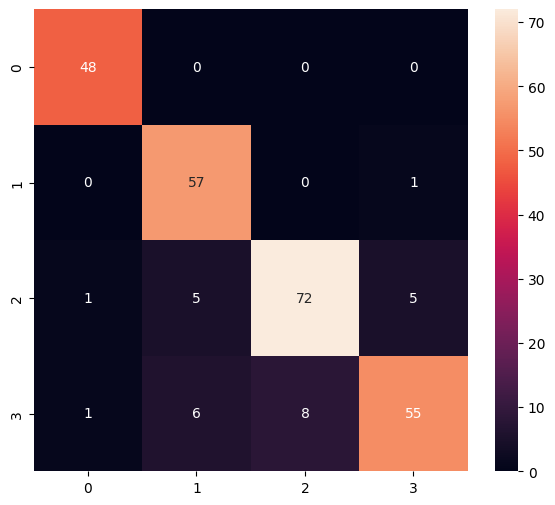

Classification Report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        48
           1       0.84      0.98      0.90        58
           2       0.90      0.87      0.88        83
           3       0.90      0.79      0.84        70

    accuracy                           0.90       259
   macro avg       0.90      0.91      0.90       259
weighted avg       0.90      0.90      0.89       259



In [16]:
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix, classification_report 

def print_confusion_matrix(Y_true, Y_pred, report=True):
    labels = sorted(list(set(Y_true)))
    cmx_data = confusion_matrix(Y_true, Y_pred, labels=labels)

    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    fig, ax = plt.subplots(figsize=(7,6))
    sns.heatmap(df_cmx, annot=True, fmt='g', square=False)
    ax.set_ylim(len(set(Y_true)), 0)
    plt.show()

    if report:
        print('Classification Report')
        print(classification_report(Y_test, Y_pred))

Y_pred = model.predict(X_test)
Y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(Y_test, Y_pred)
        

In [17]:
model.save(model_save_path, include_optimizer=False)
model = tf.keras.models.load_model(model_save_path)

/opt/anaconda3/envs/gesture_recognition/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [18]:
tflite_save_path = 'model/point_history_classifier/point_history_classifier.tflite'

In [20]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)  # converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /var/folders/v6/rj0rjt8x0c9_f_dcfqgnsg6r0000gn/T/tmp9c0fmlgr/assets


INFO:tensorflow:Assets written to: /var/folders/v6/rj0rjt8x0c9_f_dcfqgnsg6r0000gn/T/tmp9c0fmlgr/assets
2026-01-16 14:22:53.575358: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2026-01-16 14:22:53.575563: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2026-01-16 14:22:53.576529: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/v6/rj0rjt8x0c9_f_dcfqgnsg6r0000gn/T/tmp9c0fmlgr
2026-01-16 14:22:53.577034: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2026-01-16 14:22:53.577039: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/v6/rj0rjt8x0c9_f_dcfqgnsg6r0000gn/T/tmp9c0fmlgr
2026-01-16 14:22:53.579401: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2026-01-16 14:22:53.601709: I tensorflow/cc/saved_model/loader.cc:217] Running initialization

5788

In [21]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [22]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)

[{'name': 'serving_default_input_2:0', 'index': 0, 'shape': array([ 1, 32], dtype=int32), 'shape_signature': array([-1, 32], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [24]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [25]:
%%time
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 734 μs, sys: 3.22 ms, total: 3.96 ms
Wall time: 6.48 ms


In [26]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[5.49654578e-05 5.73570669e-01 1.19988486e-01 3.06385875e-01]
1
